## Проект: оценка и предоставление результатов проведения а/в тестирования двух дизайнов email рассылки.
#### Задача:– сравнить 2 группы и ответить на вопрос:сравнить 2 группы и ответить на вопрос: есть ли отличия в поведении участников в зависимости от макета (дизайна) письма?

#### Выполнил: Кашаев Андрей

### 1 Шаг Преданализ данных  и их качество
### 2 Шаг Статистический анализ и тестирование

#### 1 Шаг Преданализ данных  и их качество

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import math as mth
from scipy import stats as st

# размер графиков
rcParams['figure.figsize'] = 11,8

In [3]:
df = pd.read_excel('Данные.xlsx') # прочитаем данные

In [4]:
df.head()

,Группа,ID потребителя,Флаг доставки Email,Флаг прочтения Email,Флаг перехода по Email,Продажи в мобильном приложении,Продажи Тотал
0,Группа А,5066305263,1,N,0,NaN,350.0
1,Группа Б,5070957036,1,N,0,NaN,NaN
2,Группа А,5071201643,1,N,0,NaN,NaN
3,Группа А,5071882995,1,N,0,NaN,NaN
4,Группа А,5075332931,1,N,0,NaN,NaN


In [155]:
# Переименцум столбцы для удобства в латиницу
df = df.rename(columns={'Группа ': 'grp_ts', 'ID потребителя': 'id', 'Флаг доставки Email': 'flag_to',
       'Флаг прочтения Email': 'flag_read', 'Флаг перехода по Email':'flag_clic',
       'Продажи в мобильном приложении': 'sales_mob', 'Продажи Тотал': 'sales_tot'})

In [156]:
df.head() # Оценим манипуляции

,grp_ts,id,flag_to,flag_read,flag_clic,sales_mob,sales_tot
0,Группа А,5066305263,1,N,0,NaN,350.0
1,Группа Б,5070957036,1,N,0,NaN,NaN
2,Группа А,5071201643,1,N,0,NaN,NaN
3,Группа А,5071882995,1,N,0,NaN,NaN
4,Группа А,5075332931,1,N,0,NaN,NaN


In [157]:
df.info()# Постмотрим на данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 7 columns):
grp_ts       10462 non-null object
id           10462 non-null int64
flag_to      10462 non-null int64
flag_read    10462 non-null object
flag_clic    10462 non-null int64
sales_mob    122 non-null float64
sales_tot    1653 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 572.2+ KB


###### Видно, что целевая переменная - 'продажи в мобильном приложении' практически не запонена.

In [158]:
df_ad = df.loc[(df['grp_ts'] == 'Группа А')]
df_bd = df.loc[(df['grp_ts'] == 'Группа Б')] # разделим датафрейм на группы для их оценки

In [159]:
display(df_ad.describe(), df_bd.describe())  

,id,flag_to,flag_clic,sales_mob,sales_tot
count,5.231000e+03,5231.000000,5231.000000,69.000000,811.000000
mean,7.186113e+12,0.990250,0.048557,580.434783,1250.240444
std,9.041688e+11,0.098267,0.214960,1155.874936,5653.509483
min,5.066305e+09,0.000000,0.000000,50.000000,25.000000
25%,7.372654e+12,1.000000,0.000000,125.000000,100.000000
50%,7.462781e+12,1.000000,0.000000,290.000000,200.000000
75%,7.493896e+12,1.000000,0.000000,600.000000,500.000000
max,7.533239e+12,1.000000,1.000000,7830.000000,42000.000000


,id,flag_to,flag_clic,sales_mob,sales_tot
count,5.231000e+03,5231.000000,5231.000000,53.000000,842.000000
mean,7.207705e+12,0.993118,0.042248,500.660377,1349.257720
std,8.683012e+11,0.082680,0.201174,720.602738,6126.984651
min,5.070957e+09,0.000000,0.000000,30.000000,25.000000
25%,7.373385e+12,1.000000,0.000000,150.000000,100.000000
50%,7.466519e+12,1.000000,0.000000,250.000000,200.000000
75%,7.494426e+12,1.000000,0.000000,400.000000,517.500000
max,7.533239e+12,1.000000,1.000000,4410.000000,59875.000000


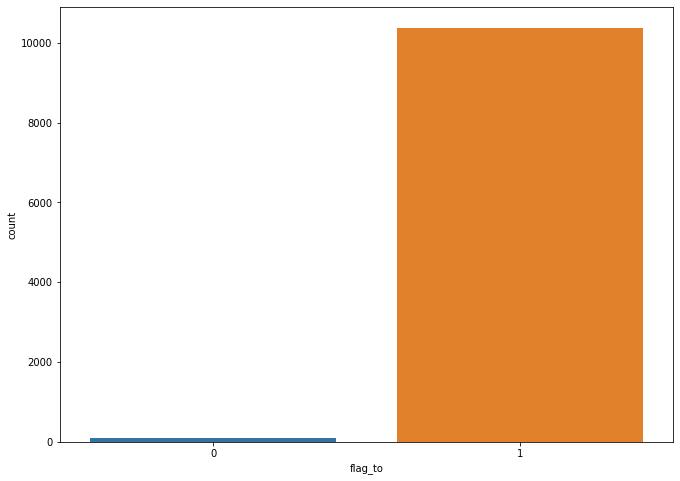

In [160]:
# Постморим на распределение доставленных писем и писем с переходом
sns.countplot(x=df["flag_to"])

Прежде, чем перейдем к анализу данных стоит уточнить, не есть ли так, что клиенты группы А наличны в группе В и наоборот.

In [161]:
len(pd.merge(df_ad, df_bd, how = 'inner', on = 'id')[['id']])

0

JOIN нам указвает, что клиенты не пересекаются в группах, а значит это четкие незавимые группы клиентов. 
И в дальнейшем мы будем применять стат.тесты для независимых выборок.

In [162]:
df.flag_to.value_counts() 

1    10375
0       87
Name: flag_to, dtype: int64

Граифик подсчета значений показвает, что кол-во недоставленных писем мизерно. Предварительно, эти письма можно исключить из анализа

Посмотрим на количество уникальных поль-лей. Может так оказатся, что одному пользователю было доставлено два письма

Стоит сказать, что кол-во доставленных и недоставлевнных писем в группах одиноаково, так и кол-во пользователей в тесте одинаково. Так как нам не интересны позиции по недоставленным письмам,  то стоит исключиь из анализа эти письма, ибо это тех. ошибки. Важно уточнить, что группы  А и В одинаковы и соразмерны. 

In [138]:
df = df.loc[(df['flag_to'] == 1)]

Не менее важно посмотреть как выглядит распределение по открытию писем в группах

In [139]:
df_cl = df.groupby(['grp_ts']).agg({'flag_clic':'sum','id':'nunique'}).reset_index()
df_cl['con_cl'] =  (df_cl['flag_clic']/df_cl['id']*100).round(2)
df_cl

,grp_ts,flag_clic,id,con_cl
0,Группа А,254,5180,4.90
1,Группа Б,221,5195,4.25


Видим, что конверсия по кликам в групе А чуть выше, чем в группе В. Вообще ничего не значить. Посмотрим, что если посмотреть на целевую переменную покупкив моб. приложении. Сделаем тоже самое

In [140]:
df_cl = df.groupby(['grp_ts']).agg({'sales_mob':'sum','id':'nunique'}).reset_index()
df_cl['con_cl'] =  (df_cl['sales_mob']/df_cl['id']*100).round(2)
df_cl

,grp_ts,sales_mob,id,con_cl
0,Группа А,40050.0,5180,773.17
1,Группа Б,26535.0,5195,510.78


Из таблице выше, заключаем, что в срднем один пользователь, приносить в группе А на 35% у.е больше чем по группе В. 
Уже, что-то прояснятется, но стоит провести статистические тесты. Где рандомно сопостаим кол-во id в группах.

Проверим гипотезу о равенстве долей в двух группах. НО прежде проверим гипотезу на нормальное распределение данных.Методом шапиро уилка. В зависимомти от распределения, стоит выбирать статист. критерий

#### 2 Шаг Статистический анализ и тестирование

In [141]:
sample_1 = df['sales_tot'].fillna(0)

alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(sample_1)
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


С учетом, того, что данные не нормально распределены, для проверики гипотезы будем использовать непараметрически критерий 
Уилкоксона-Манна-Уитни ддя независимых выборок

In [142]:
# Заменим пропуски на 0 для лучшей работы стат.тестов
df['sales_mob'] = df['sales_mob'].fillna(0)
df['sales_tot'] = df['sales_tot'].fillna(0)


In [143]:
# Ращдедим группы
df_a = df.loc[(df['grp_ts'] == 'Группа А')]
df_b = df.loc[(df['grp_ts'] == 'Группа Б')]

In [144]:
from scipy import stats as st
import numpy as np
import cmath as сmth

alpha = 0.05  # критический уровень статистической значимости

purchases = np.array([254, 5180])
leads = np.array([221, 5195])

# пропорция успехов в первой группе:
p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
p2 = purchases[1]/leads[1]

# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
difference = p1 - p2


z_value = difference / (0.5)**(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.879023673792463
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По уроне долей гипотезе о их равенстве отвеграется. Однако целевая переменная у нас другая - продажив мобильном приложении. 
Посмотрим как она будет вести себя на стат. тестах

In [146]:
sample_1 = df_a['sales_mob'].sample(5170, random_state=42)
sample_2 = df_b['sales_mob'].sample(5170, random_state=42)

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(sample_1, sample_2)


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 


p-значение:  0.0723539878821017
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


В целом гипотеза о различиях в двух группах не подтверждается

Уточним как ведет себя переменная  "клики" на тесте манна-уитни. Может быть там, что-то иное

In [147]:
from scipy import stats as st
import numpy as np

sample_1 = df_a['flag_clic'].sample(5170, random_state=42)
sample_2 = df_b['flag_clic'].sample(5170, random_state=42)

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(sample_1, sample_2)


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.060187618468605646
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


К сожалению нет!!! В карйнем случаем ожно оценить, два макета на основе переменной тотал-продажи. Вдруг работа бизнеса и дизайнеров не прошла даром

In [148]:
from scipy import stats as st
import numpy as np

sample_1 = df_a['sales_tot'].sample(5170, random_state=42)
sample_2 = df_b['sales_tot'].sample(5170, random_state=42)

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(sample_1, sample_2)


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.13912909254143357
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Заключаем на уровне 0.05 не дудалось отвергнуть нулевую гипотезу, а именно что есть различия в поведениях двух групп.И говорить, что какой-то макет письма, лучше другого непроиходится. Ни по сликам,ни по продажам в мобильном приложеннии, и уж точно  не по тотал продажам.

Одноко, может стоит для лучшей убедительности провести ПСЕВДОстатистический эксперемент.(ВыйдеМ за рамки КОРРЕКТНОСТИ) Возьмем из каждой группы, только "кликовых" клиентов(254 и 221)  и на основе их поведения в переменных моб. и тотал продажах возможно зафиксируем разницу.

In [149]:
df_a = df_a.loc[(df['flag_clic'] == 1)]
df_b = df_b.loc[(df['flag_clic'] == 1)]

In [150]:
from scipy import stats as st
import numpy as np

sample_1 = df_a['sales_mob'].sample(220,random_state=42)
sample_2 = df_b['sales_mob'].sample(220,random_state=42)

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(sample_1, sample_2)


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )  

p-значение:  0.03041085912667446
Отвергаем нулевую гипотезу: разница статистически значима


Заключаем: как ни странно, псевдоэксперемент фиксирует, разницу в группах по переменой продажи в мобильном приложении. НО можно ли говрить, что это ответсвенно. Думаю вряд - ли. P.S Исключал  значение random_state и провел 10 итераций кода с продажами. Результат следующий: [0,0,1,0,0,1,0,0,1,1] 6- нет разницы, а в 4 есть. Вместе с тем, что надо понимать, что это псевдоэкперент. (грубо говоря переходим рамки корректности). Но что будет если посмомтреть на на переменную."тотал- продажи"

In [151]:
from scipy import stats as st
import numpy as np

sample_1 = df_a['sales_tot'].sample(220, random_state=42)
sample_2 = df_b['sales_tot'].sample(220, random_state=42)

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(sample_1, sample_2)


print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.3868751492413143
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


К сожалению, все эксперменты показывают, отсутвие разницы в способности приносить value в зависимомоти от нового/старого макета письма.

### Вывод на главный вопрос: есть ли отличия в поведении участников в зависимости от макета (дизайна) письма? 
### Категоричеки нет!!! .

###### Выполнило: Кашаев Андрей